In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser
import os

In [2]:
# DATA

# import

station_id=5001
file_path = os.path.join(r'D:\FMF magisterij\Matematika z računalnikom', f'ELES-MAS-{station_id}-2020-2023.csv.gz')
data = pd.read_csv(file_path, compression='gzip')
data = data[data['data_validity'] <= 32]
data.drop('measurement_location_inst_id', axis=1, inplace=True)
data['acquisition_timestamp'] = pd.to_datetime(data['acquisition_timestamp'], utc=True)

# pivoting
new_data = data.pivot_table(index='acquisition_timestamp', columns='parameter_type', values='value').reset_index()
new_data.set_index('acquisition_timestamp', inplace=True)


# ambient temperature
temperature = new_data[['AMBIENT_TEMPERATURE']]
print(temperature)

# count the NaN values
nan_count_temperature = temperature['AMBIENT_TEMPERATURE'].isna().sum()
print(nan_count_temperature)
# there are no NaN values

# check for missing measurements (skipped times)
complete_range = pd.date_range(start=temperature.index.min(), end=temperature.index.max(), freq='5T')
missing_timestamps = complete_range.difference(temperature.index)
print(len(missing_timestamps))
#print(complete_range)
df_complete_range = pd.DataFrame(index=complete_range)
len(df_complete_range)
# we have 271508 measurements, there are 5112 missing measurment out of 276620 time steps in the whole time range

# merge all the air pressure measurements with all the time steps. missing measurment will be NaN values for now
temperature_incomplete = df_complete_range.merge(temperature, left_index=True, right_index=True, how='left')
# print(temperature_incomplete)
temperature_incomplete.isna().sum() # okay

# missing measurements are filled with the next available measurement
temperature_all = temperature_incomplete.bfill()
print(temperature_all)
print(temperature_all.isna().sum()) # okay

str(temperature_all.index.dtype) # okay

parameter_type             AMBIENT_TEMPERATURE
acquisition_timestamp                         
2020-10-13 10:20:00+00:00                  7.4
2020-10-13 10:25:00+00:00                  7.5
2020-10-13 10:30:00+00:00                  7.4
2020-10-13 10:35:00+00:00                  7.5
2020-10-13 10:40:00+00:00                  7.6
...                                        ...
2023-05-31 21:35:00+00:00                 14.0
2023-05-31 21:40:00+00:00                 13.9
2023-05-31 21:45:00+00:00                 13.9
2023-05-31 21:50:00+00:00                 13.9
2023-05-31 21:55:00+00:00                 13.9

[271508 rows x 1 columns]
0
5112
                           AMBIENT_TEMPERATURE
2020-10-13 10:20:00+00:00                  7.4
2020-10-13 10:25:00+00:00                  7.5
2020-10-13 10:30:00+00:00                  7.4
2020-10-13 10:35:00+00:00                  7.5
2020-10-13 10:40:00+00:00                  7.6
...                                        ...
2023-05-31 21:35:00+00:00 

'datetime64[ns, UTC]'

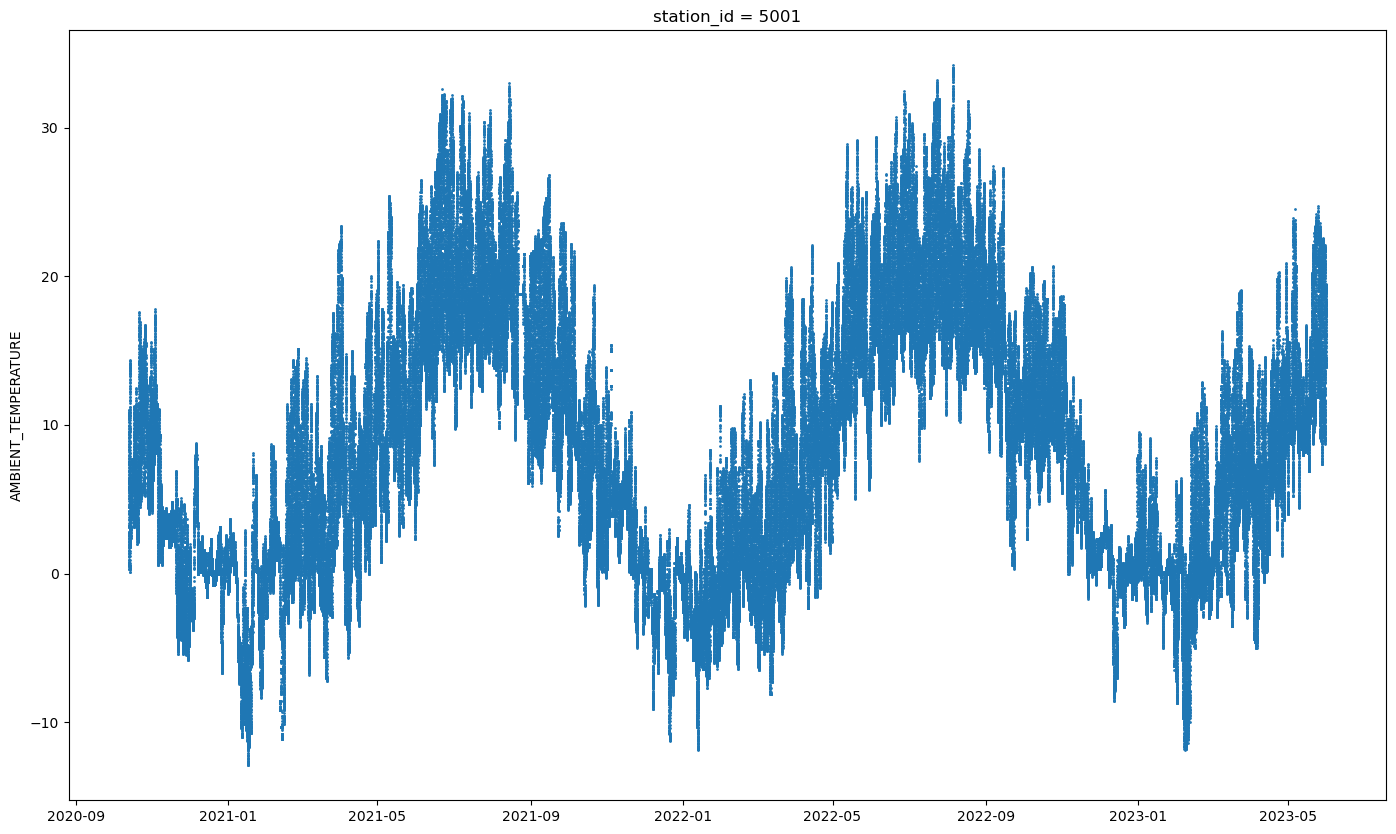

In [3]:
# plot 'AMMBIENT_TEMPERATURE'
fig, ax = plt.subplots(figsize=(17, 10))
ax.scatter(temperature_all.index, temperature_all['AMBIENT_TEMPERATURE'],s=1)
ax.set_ylabel('AMBIENT_TEMPERATURE')  
ax.set_title(f'station_id = {station_id}')  
plt.show()

                           AMBIENT_TEMPERATURE
2020-10-13 10:00:00+00:00             7.687500
2020-10-13 11:00:00+00:00             8.958333
2020-10-13 12:00:00+00:00            10.183333
2020-10-13 13:00:00+00:00            10.716667
2020-10-13 14:00:00+00:00            10.833333
...                                        ...
2023-05-31 17:00:00+00:00            18.708333
2023-05-31 18:00:00+00:00            17.141667
2023-05-31 19:00:00+00:00            15.525000
2023-05-31 20:00:00+00:00            14.341667
2023-05-31 21:00:00+00:00            13.983333

[23052 rows x 1 columns]


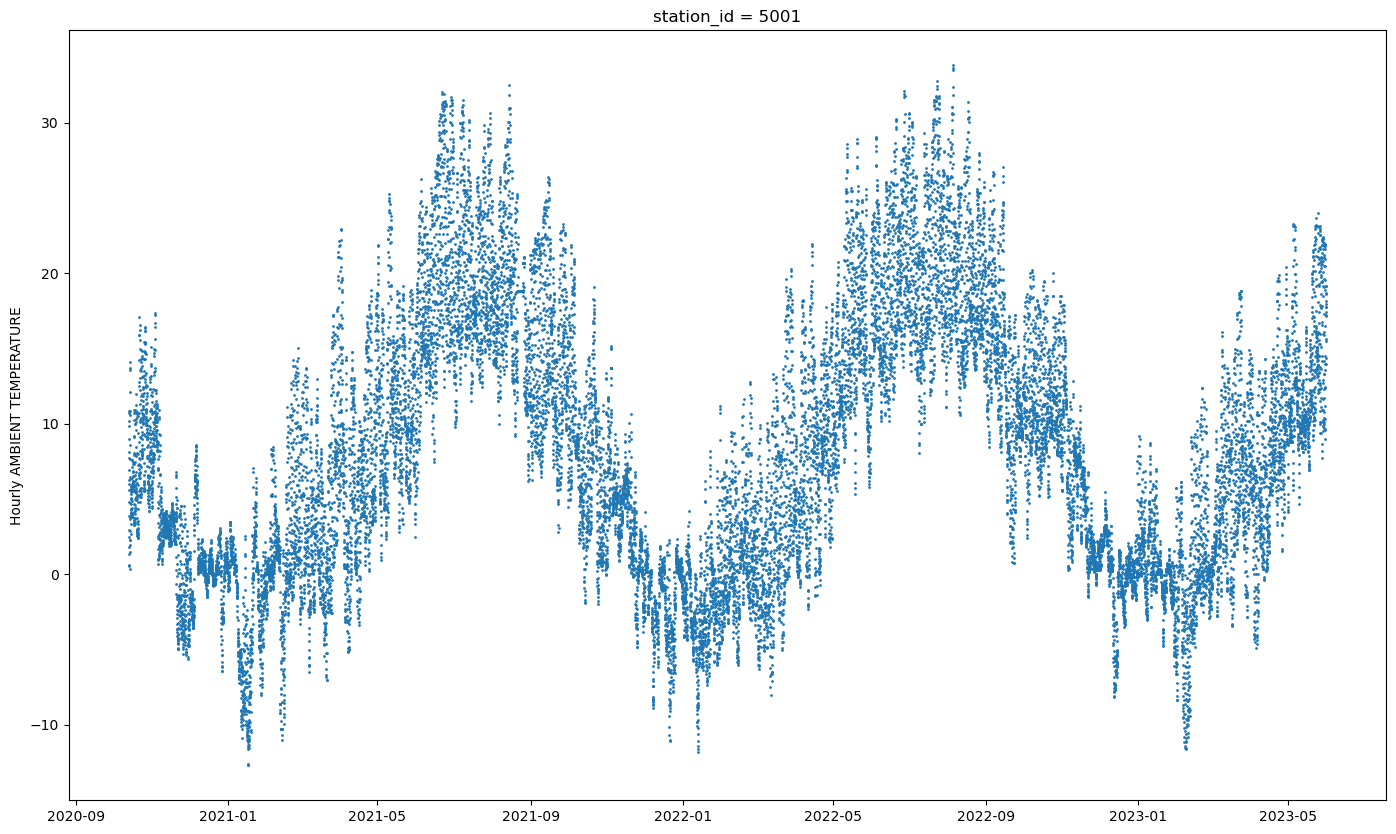

In [4]:
# hourly data
# sum the values for each hour and take the mean

str(temperature_all.index.dtype) # okay
temperature_hourly = temperature_all.resample('H').mean()
print(temperature_hourly)

# plot hourly 'AMBIENT_TEMPERATURE'
fig, ax = plt.subplots(figsize=(17, 10))
ax.scatter(temperature_hourly.index, temperature_hourly['AMBIENT_TEMPERATURE'],s=1)
ax.set_ylabel('Hourly AMBIENT TEMPERATURE')  
ax.set_title(f'station_id = {station_id}')  
plt.show()

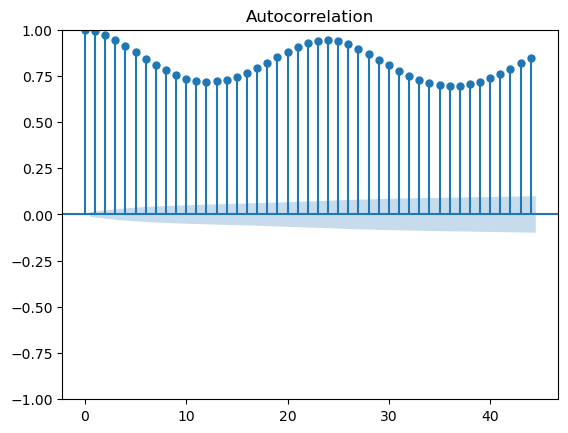

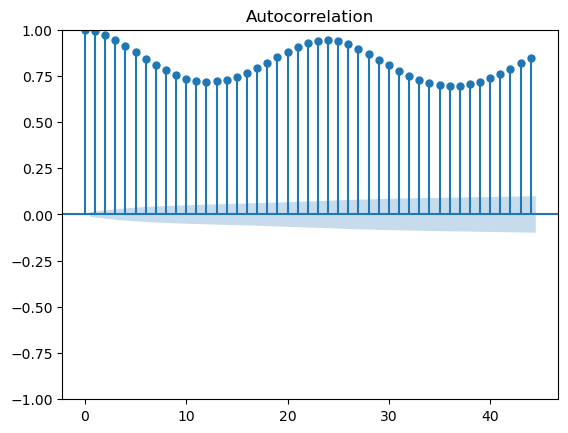

In [5]:
# ARIMA(p, d, q)

# let's look for a suggestion for d by looking at the autocorellation function (ACF) plot

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(temperature_hourly['AMBIENT_TEMPERATURE'])

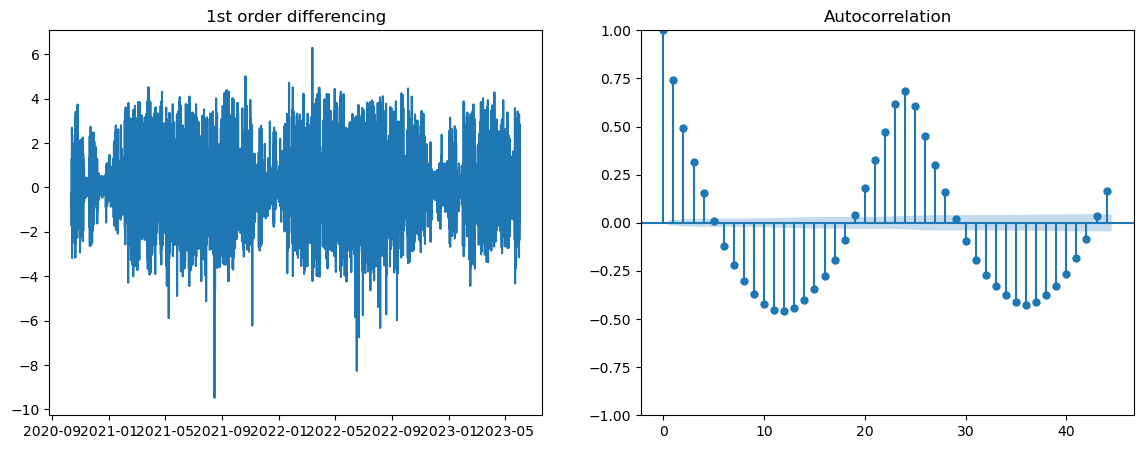

In [6]:
# first differencing and ACF

f = plt.figure(figsize=(14, 5))
ax1 = f.add_subplot(121)
ax1.set_title('1st order differencing')
ax1.plot(temperature_hourly['AMBIENT_TEMPERATURE'].diff())

ax2 = f.add_subplot(122)
plot_acf(temperature_hourly['AMBIENT_TEMPERATURE'].diff().dropna(), ax=ax2)
plt.show()


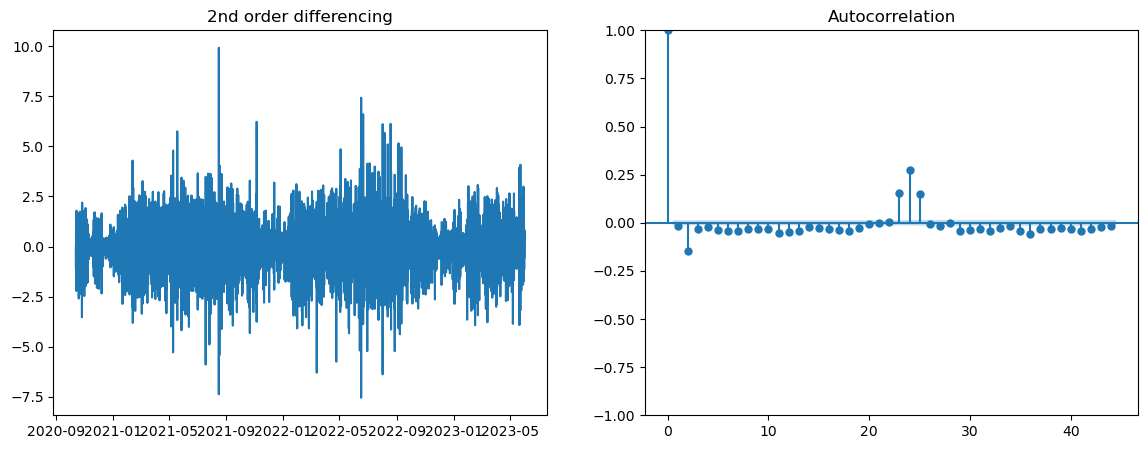

In [7]:
# second differencing and ACF

f = plt.figure(figsize=(14, 5))
ax1 = f.add_subplot(121)
ax1.set_title('2nd order differencing')
ax1.plot(temperature_hourly['AMBIENT_TEMPERATURE'].diff().diff())

ax2 = f.add_subplot(122)
plot_acf(temperature_hourly['AMBIENT_TEMPERATURE'].diff().diff().dropna(), ax=ax2)
plt.show()

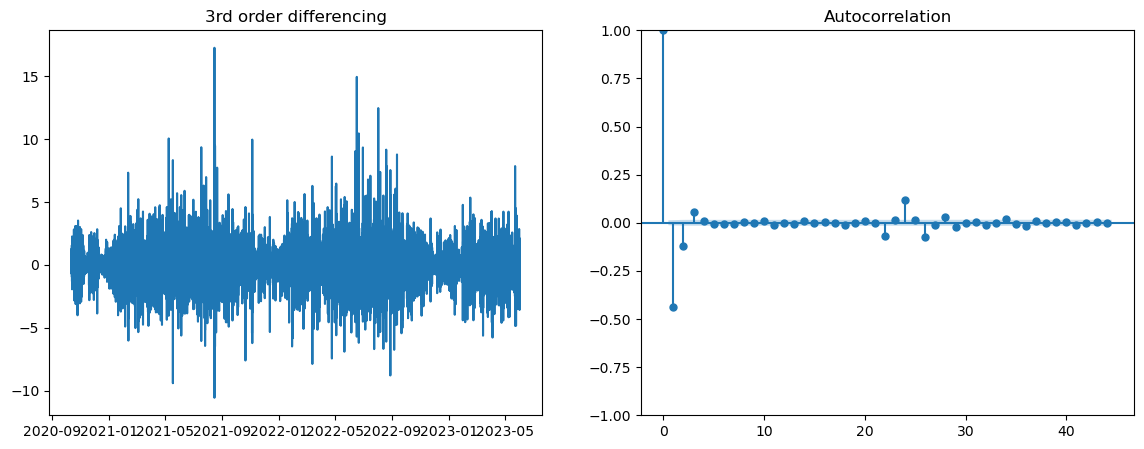

In [8]:
# third differencing and ACF

f = plt.figure(figsize=(14, 5))
ax1 = f.add_subplot(121)
ax1.set_title('3rd order differencing')
ax1.plot(temperature_hourly['AMBIENT_TEMPERATURE'].diff().diff().diff())

ax2 = f.add_subplot(122)
plot_acf(temperature_hourly['AMBIENT_TEMPERATURE'].diff().diff().diff().dropna(), ax=ax2)
plt.show()

For deciding the appropriate order of differencind, we can to the Augmented Dickey-Fuller test. (more about it for the report is in the air_pressure files). The ADF test aims to reject the null hypothesis that the given time-series data is non-stationary. It calculates the p-value and compares it with a threshold value or significance level of 0.05. If the p-value is less than this level, then the data is stationary; else, the differencing order is incremented by one.

In [9]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(temperature_hourly['AMBIENT_TEMPERATURE'].dropna())
print('original data p-value:', result[1])

result = adfuller(temperature_hourly['AMBIENT_TEMPERATURE'].diff().dropna())
print('1-diff data p-value:', result[1])

result = adfuller(temperature_hourly['AMBIENT_TEMPERATURE'].diff().diff().dropna())
print('2-diff data p-value:', result[1])

result = adfuller(temperature_hourly['AMBIENT_TEMPERATURE'].diff().diff().diff().dropna())
print('3-diff data p-value:', result[1])

original data p-value: 0.0015578947243512005
1-diff data p-value: 0.0
2-diff data p-value: 0.0
3-diff data p-value: 0.0


The data is likely stationary.

Now we will look for the best ARIMA(p,d,q) model to fit to the data.

In [11]:
# 1ST WAY OF FINDING THE BEST FIT

# ARIMA for all the hourly ambient temperature data
from pmdarima import auto_arima
stepwise_fit = auto_arima(temperature_hourly, trace=True,
suppress_warnings=True)
# it takes around 10 min

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=50469.450, Time=13.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=69218.443, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=50873.932, Time=0.90 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=55963.502, Time=2.79 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=69216.444, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=50476.504, Time=5.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=50474.208, Time=9.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=30.87 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=46572.351, Time=32.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=50403.425, Time=6.85 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=47298.401, Time=41.00 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=45946.688, Time=34.94 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=50400.185, Time=28.10 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=46099.778, Time=39.52 sec
 ARIMA(2,1,5)(0,0,

                                SARIMAX Results                                
Dep. Variable:     AMBIENT_TEMPERATURE   No. Observations:                23052
Model:                  ARIMA(2, 1, 5)   Log Likelihood              -22822.785
Date:                 Sun, 19 May 2024   AIC                          45661.571
Time:                         12:29:55   BIC                          45725.934
Sample:                     10-13-2020   HQIC                         45682.485
                          - 05-31-2023                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9147      0.001   1309.249      0.000       1.912       1.918
ar.L2         -0.9810      0.001   -689.201      0.000      -0.984      -0.978
ma.L1         -1.2780      0.004   -344.226 

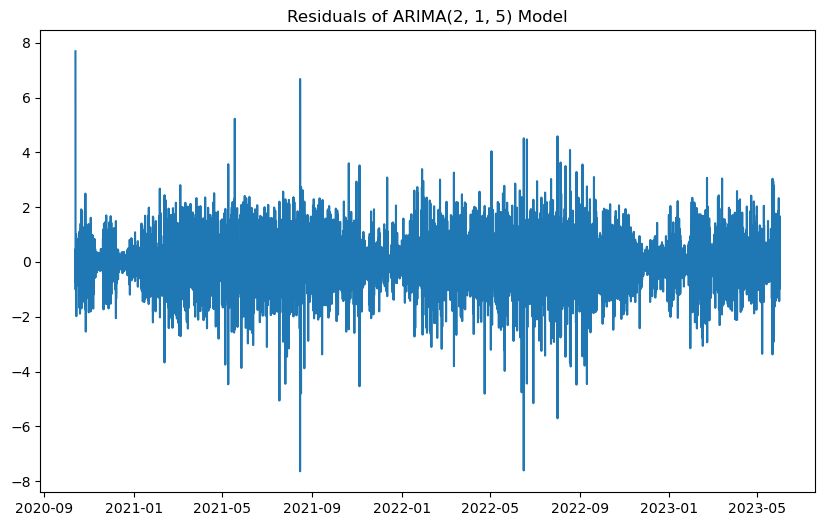

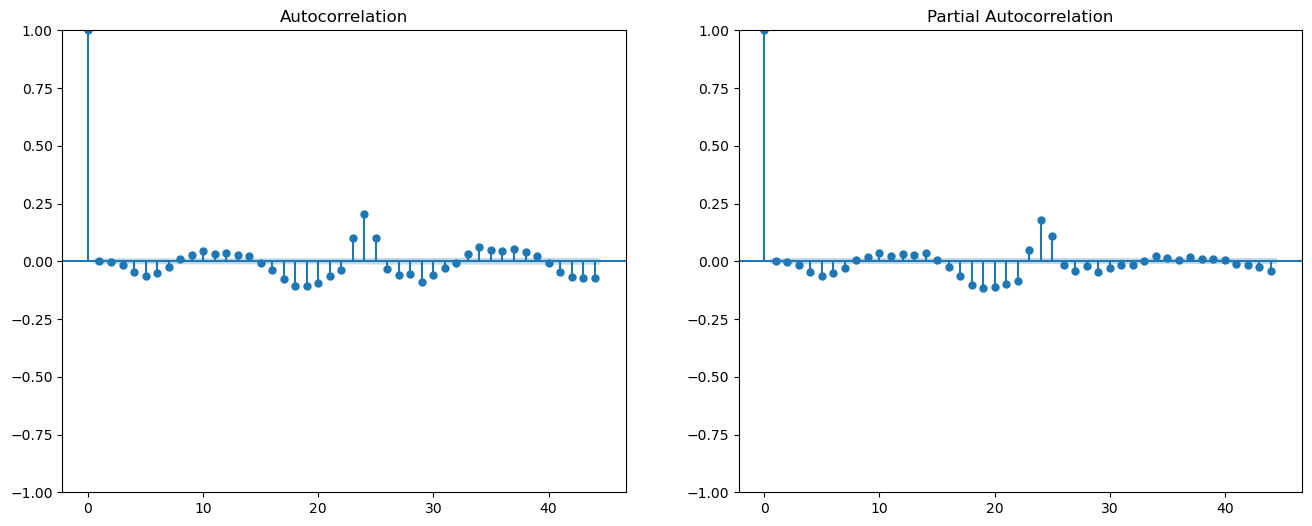

In [12]:
# fit the model 

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# fit the best model
best_model = ARIMA(temperature_hourly, order=(2,1,5))   # change order accordingly
best_fit = best_model.fit()

# summary of the best model
print(best_fit.summary())

# residuals of the best model
residuals_best = best_fit.resid

# plot residuals
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(residuals_best)
plt.title(f'Residuals of ARIMA{2,1,5} Model')
plt.show()

# plot ACF and PACF of the residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(residuals_best, ax=ax[0], alpha=0.05)
plot_pacf(residuals_best, ax=ax[1], alpha=0.05)
plt.show()

        Order           AIC           BIC
80  (4, 1, 2)  45620.807625  45677.125876
99  (5, 1, 3)  45627.426955  45699.836134
47  (2, 1, 5)  45661.570688  45725.934404
46  (2, 1, 4)  45679.351424  45735.669675
65  (3, 1, 5)  45682.345363  45754.754543
Best ARIMA order: (4, 1, 2)
                                SARIMAX Results                                
Dep. Variable:     AMBIENT_TEMPERATURE   No. Observations:                23052
Model:                  ARIMA(4, 1, 2)   Log Likelihood              -22803.404
Date:                 Sun, 19 May 2024   AIC                          45620.808
Time:                         12:55:40   BIC                          45677.126
Sample:                     10-13-2020   HQIC                         45639.107
                          - 05-31-2023                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-

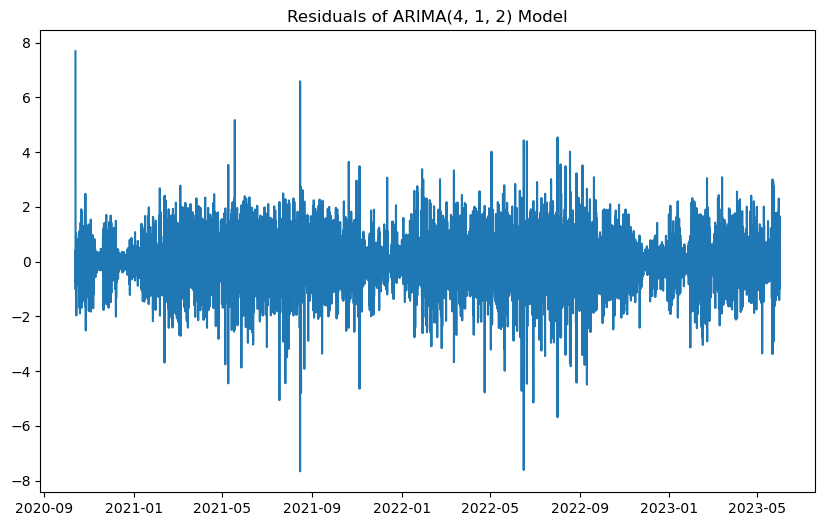

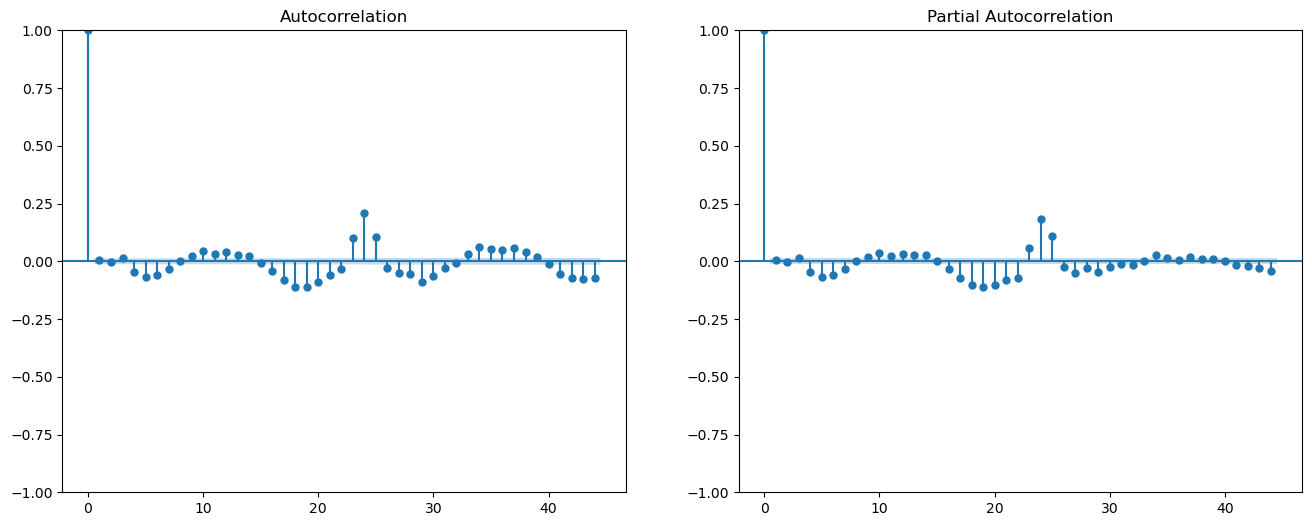

In [13]:
# 2ND WAY OF FINDING THE BEST FIT

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# define the range for p, d, q parameters
p = range(0, 6)
d = range(0, 3)
q = range(0, 6)

# a list to store the results
results = []

# perform grid search
for i in p:
    for j in d:
        for k in q:
            order = (i, j, k)
            try:
                model = ARIMA(temperature_hourly, order=order)
                fit = model.fit()
                aic = fit.aic
                bic = fit.bic
                results.append((order, aic, bic))
            except:
                continue

# convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['Order', 'AIC', 'BIC'])

# sort the results by AIC and BIC
results_df = results_df.sort_values(by='AIC')

# print the top 5 models
print(results_df.head())

# choose the best model based on the lowest AIC
best_order = results_df.iloc[0]['Order']
print(f"Best ARIMA order: {best_order}")

# fit the best model
best_model = ARIMA(temperature_hourly, order=best_order)
best_fit = best_model.fit()

# check the summary of the best model
print(best_fit.summary())

# residuals of the best model
residuals_best = best_fit.resid

# plot residuals
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(residuals_best)
plt.title(f'Residuals of ARIMA{best_order} Model')
plt.show()

# plot ACF and PACF of the residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(residuals_best, ax=ax[0])
plot_pacf(residuals_best, ax=ax[1])
plt.show()

In [10]:
# data for 2020, 2021, 2022
# fit the best model to this data
# 2 best ARIMAs: (2,1,5) and (4,1,2) - use both
# forecast the next 6 hours 
# compare forecast from ARIMA and simple model with actual values (maybe 2 simple models)
# plot forecasts, plot errors

temperature_20_21_22 = temperature_hourly.loc[(temperature_hourly.index.year == 2020) | (temperature_hourly.index.year == 2021) | (temperature_hourly.index.year == 2022) , 'AMBIENT_TEMPERATURE']
print(temperature_20_21_22)

2020-10-13 10:00:00+00:00     7.687500
2020-10-13 11:00:00+00:00     8.958333
2020-10-13 12:00:00+00:00    10.183333
2020-10-13 13:00:00+00:00    10.716667
2020-10-13 14:00:00+00:00    10.833333
                               ...    
2022-12-31 19:00:00+00:00     2.083333
2022-12-31 20:00:00+00:00     1.658333
2022-12-31 21:00:00+00:00     0.875000
2022-12-31 22:00:00+00:00     0.950000
2022-12-31 23:00:00+00:00     0.750000
Freq: H, Name: AMBIENT_TEMPERATURE, Length: 19430, dtype: float64


Now we will create a simple models to later compare it with the ARIMA models we fitted to the data.

Simple model: Average of the previous 3 days is the value for the next day.

We fitted ARIMA models to all the hourly data. We will fit the models to the data for just 2020, 2021 and 2022 and then forecast 6 hours (6 steps into the 'future', which is the start of the year 2023).

We will then compare the models with the actual data and see which model gives the best forecast. Hopefully it is the ARIMA model.

In [41]:
# 1st simple model
# average of the previous 3 days is the value for the next day

def last_3_days_average(data, forecasted_steps):
    # Forecasts the next values based on the average of the last 3 days at the same time.
    forecast = []

    for step in range(forecasted_steps):

        next_time_step = data.index[-1] + pd.Timedelta(hours=1) # finds out the next time step
        
        last_3_days = [
            next_time_step - pd.Timedelta(days=i) for i in range(1, 4)     # gets the same hour from the last 3 days
        ]
        
        values = [data[data.index == dt].values for dt in last_3_days] # extracts the values at the same hour from the last 3 days
        values = [val[0] if len(val) > 0 else np.nan for val in values]
        
        forecast_value = np.nanmean(values) # mean of the last 3 days
        
        forecast.append(forecast_value)
        
        data = pd.concat([data, pd.Series([forecast_value], index=[next_time_step])]) # adds the forecasted value to the data for the next iteration

    return pd.Series(forecast, index=[data.index[-forecasted_steps + i] for i in range(forecasted_steps)])

last_3_days_average(temperature_20_21_22, 6)


2023-01-01 00:00:00+00:00   -0.630556
2023-01-01 01:00:00+00:00   -0.750000
2023-01-01 02:00:00+00:00   -0.866667
2023-01-01 03:00:00+00:00   -0.819444
2023-01-01 04:00:00+00:00   -0.913889
2023-01-01 05:00:00+00:00   -0.919444
dtype: float64

In [42]:
# 2nd simple model
# today's measurement is tomorrow's forecast

def today_is_tomorrow(data, forecasted_steps):

    forecast = []

    for step in range(forecasted_steps):

        next_time_step = data.index[-1] + pd.Timedelta(hours=1)
        
        same_hour_last_day = next_time_step - pd.Timedelta(days=1)
        
        forecast_value = data.loc[same_hour_last_day]
        
        forecast.append(forecast_value)
        
        data = pd.concat([data, pd.Series([forecast_value], index=[next_time_step])])

    return pd.Series(forecast, index=[data.index[-forecasted_steps + i] for i in range(forecasted_steps)])

today_is_tomorrow(temperature_20_21_22, 6)   


2023-01-01 00:00:00+00:00    0.016667
2023-01-01 01:00:00+00:00   -0.250000
2023-01-01 02:00:00+00:00   -0.366667
2023-01-01 03:00:00+00:00    0.116667
2023-01-01 04:00:00+00:00   -0.075000
2023-01-01 05:00:00+00:00   -0.191667
dtype: float64

In [32]:
# ARIMA(2,1,5) (1st fit)

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")


# fit
model_215 = ARIMA(temperature_20_21_22, order=(2,1,5))
fit_215 = model_215.fit()

# summary of the fit
print(fit_215.summary())

# ARIMA forecast for 6 steps into the future

forecast_result = fit_215.get_forecast(steps=6)
forecast_values = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

print("Forecasted values:", forecast_values)
print("95% Confidence intervals of forecasts:", conf_int)


                                SARIMAX Results                                
Dep. Variable:     AMBIENT_TEMPERATURE   No. Observations:                19430
Model:                  ARIMA(2, 1, 5)   Log Likelihood              -19445.998
Date:                 Sun, 19 May 2024   AIC                          38907.996
Time:                         22:05:01   BIC                          38970.992
Sample:                     10-13-2020   HQIC                         38928.636
                          - 12-31-2022                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9098      0.002   1132.916      0.000       1.906       1.913
ar.L2         -0.9754      0.002   -596.540      0.000      -0.979      -0.972
ma.L1         -1.2744      0.004   -324.030 

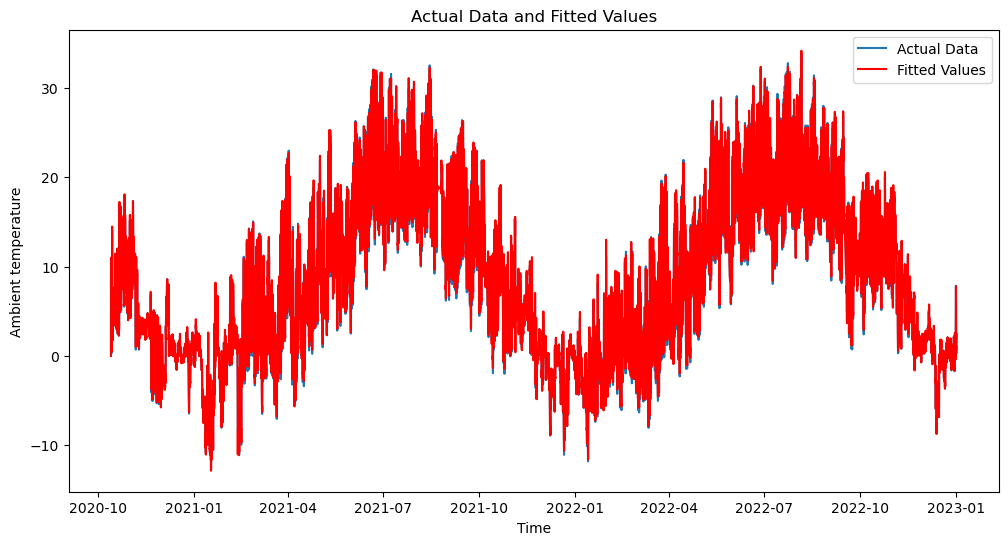

In [34]:
# plot actual data and fitted values
# fitted values
fitted_values_215 = fit_215.fittedvalues

plt.figure(figsize=(12,6))
plt.plot(temperature_20_21_22.index, temperature_20_21_22, label='Actual Data')
plt.plot(temperature_20_21_22.index, fitted_values_215, color='red', label='Fitted Values')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Ambient temperature')
plt.title('Actual Data and Fitted Values')
plt.show()

In [35]:
# actual measurements for 6 steps into the future
temp_hourly = temperature_hourly['AMBIENT_TEMPERATURE']
actual_values_temperature_23 = temp_hourly['2023'].head(6)
print(actual_values_temperature_23)

2023-01-01 00:00:00+00:00    0.000000
2023-01-01 01:00:00+00:00   -0.116667
2023-01-01 02:00:00+00:00    0.050000
2023-01-01 03:00:00+00:00   -0.133333
2023-01-01 04:00:00+00:00   -0.208333
2023-01-01 05:00:00+00:00    0.041667
Freq: H, Name: AMBIENT_TEMPERATURE, dtype: float64
